In [9]:
#coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from ncov.reader import get_data,watch_data
## test:
# get_data('湖北', '武汉', '2020-01-01', '2020-02-08')

In [10]:
import torch
from torch.nn.parameter import Parameter
torch.set_default_tensor_type(torch.DoubleTensor)

In [82]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init, gamma_2_init, theta_init):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=True))
        self.gamma_1 = torch.tensor([0.])
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.alpha = torch.tensor([1.])
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        self.omega = torch.tensor([0.])
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))


    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def act(self, X):
        # return torch.nn.LeakyReLU(0.1)(X)
        # return torch.relu(X)
        return torch.pow(X, 2)

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = S + self.act(self.omega)*Exposed - self.act(self.beta)*confirm*S/self.N # dS/dt
        E = Exposed + self.act(self.beta)*confirm*S/self.N - (self.act(self.alpha)+self.act(self.omega))*Exposed # dE/dt

        I = confirm + self.act(self.alpha)*Exposed - (self.act(self.gamma_2)+ self.act(self.theta))*confirm # dI/dt
        R = recover + self.act(self.gamma_2)*confirm # dR/dt
        D = dead + self.act(self.theta)*confirm

        # I = confirm + self.act(self.alpha)*E - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        # R = recover + self.act(self.gamma_2)*I # dR/dt
        # D = dead + self.act(self.theta)*I

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.N


In [56]:

class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., beta_init=0.2586,  gamma_2_init=0.018, theta_init=0.001, E_ratio_init=3., I_init=41, R_init=2., D_init=0.):
        super(SEIR_model, self).__init__()
        self.date_len = date_len
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        # self.I = (1e-6)*self.N
        # self.E = (self.I * self.E_ratio)
        # self.R = (1e-6 / 2)*self.N
        # self.S = (self.N - self.I - self.E - self.R)
        # self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        # self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.beta = beta_init
        self.gamma_2 = gamma_2_init
        self.theta = theta_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        # self.date_total_len = self.date_len + self.pred_date_len
        for i in range(self.date_len):
            self.SEIR_cells.append(SEIR_cell(self.N,self.beta,self.gamma_2, self.theta))

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, N = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            self.N_cur = N
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, N_cur=0, beta=0, gamma_2=0, theta=0):
        if N_cur==0:
            N_cur=self.N_cur
            beta=self.beta
            gamma_2=self.gamma_2
            theta=self.theta

        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur,beta,gamma_2,theta))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, N_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor
    
        

In [37]:
def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    # accumulated_confirmed = data[I_name]
    # accumulated_death = data['accumulated_death']
    # accumulated_recovered = data[R_name]
    time_val = data[T_name].values
    
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, accumulated_confirmed, color = 'red', label = '累计确诊人数',marker = 'x')
    plt.plot(merge_time, accumulated_pred_confirmed, color = 'blue',label = '预测的累计确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [38]:
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '新增累计确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [77]:
import torch.optim as optim
import os
# def loss_fn(pred, gt):
#     T = gt.shape
#     loss = torch.tensor([0.])
#     for i in range(T.data.numpy()):
#         loss = loss + torch.mean((i+1)*torch.pow(pred[i]-gt[i],2))
    # return loss
def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path,city)
    
    model_city_date_path = os.path.join(model_city_path,date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate

def train(data, model_city_date_path, N=1e7, I_init=1e-6, R_init=1e-6/2., D_init=1e-6/6., features=['accumulated_confirmed', 'accumulated_recovered', 'accumulated_death'], max_epoches = 400):
    model_pt = os.path.join(model_city_date_path,'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat,dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len,  pred_date_len = 10, N=N, I_init=I_init, R_init=R_init, D_init=D_init)
    # Learning rate for optimizers
    lr = 0.01
    lr_init = lr
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    # I_pred_list = []
    # R_pred_list = []
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for step in range(max_epoches):
        print("Training step: ", step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S,I,E,R,D, beta,gamma_2 = model(model_inp.float())
        # print(output)
        loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_confirm = pred_I+pred_recovered+pred_dead
        # print(pred_confirmed)
        
        I_gt_tensor = Input[:,0]
        recovered_gt_tensor = Input[:,1]
        dead_gt_tensor = Input[:,2]
        confirm_gt = I_gt_tensor+recovered_gt_tensor+dead_gt_tensor
        # print(recovered_gt_tensor)
        # print(pred_confirmed.shape)
        # loss = loss_fn(pred_confirmed,confirmed_gt_tensor)
        loss = 0.1*(loss_fn(pred_confirm, confirm_gt) + loss_fn(pred_I, I_gt_tensor) + 4*loss_fn(pred_recovered, recovered_gt_tensor) + 4*loss_fn(pred_dead, dead_gt_tensor))
        # loss = loss_fn(pred_confirmed, confirmed_gt_tensor) + loss_fn(pred_recovered, recovered_gt_tensor) + loss_fn(pred_dead, dead_gt_tensor)
        print("Loss: {}".format(loss))
        if loss<loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        learning_rate = lr_decay(step,lr_init,decay_steps=300)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:",loss_min)
    return S,I,E,R,D


# model_city_date_path = make_dir('wuhan','02-03')
# features=['accumulated_confirmed', 'accumulated_recovered']
# S,I,E,R,model = train(data_wh_feat, model_city_date_path, N=2870000., I_init=41, R_init=2., features=features, max_epoches=400)

In [40]:
def load_model_predict(model_city_date_path, data, N_cur=0,beta=0,gamma_2=0,theta=0, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(N_cur=N_cur,beta=beta,gamma_2=gamma_2,theta=theta, pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    print('confirm_pred',confirm_pred)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total

    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

In [41]:
# # data_china = pd.read_excel('./ncov/data/nation_data.xlsx')
# data_china = pd.read_csv('./ncov/data/nation/nation.csv')
# data_china

In [42]:
# data_china['time'] = data_china['time'].apply(lambda x: '2020/'+x.replace('月','/').replace('日',''))
# data_china['time'] = pd.to_datetime(data_china['time'])

In [43]:
# data_china['accumulated_confirmed']

In [44]:
# model_city_date_path = make_dir('china','02-08')
# features=['accumulated_confirmed', 'accumulated_cured', 'accumulated_death']
# I_init = float(data_china['accumulated_confirmed'].iloc[0])
# R_init = float(data_china['accumulated_cured'].iloc[0])
# D_init = float(data_china['accumulated_death'].iloc[0])
# N = 13000000000.
# S_china,I_china,E_china,R_china,D_china = train(data_china, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

In [45]:
# model_city_date_path='models/china/02-08'

In [46]:
# param = {'beta_model_3': 0.09111736783585582, 'gamma_2_model_3': 0.016532860820465893, 'N_model_3': 13000000000.106674, 'theta_model_3': 0.006605514213817316}
# def change_key(param,i):
#     for k in list(param.keys()):
#         old_key = k
#         new_key = k.replace(f'_model_{i}','')
#         param[new_key]=param.pop(old_key)
#     return param
# param = change_key(param,3)
# param

In [47]:
# load_model_predict(model_city_date_path, data_china, N_cur=param['N'],beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'],city_name='全国', c='accumulated_confirmed', features=features)

In [48]:
# merge_data = pd.read_csv('./ncov/data/nation/allcity_20200209.csv')
# merge_data = merge_data.rename(columns = {'updatetime':'time'})
# merge_data['time'] = merge_data['time'].apply(lambda x: '2020/'+x)
# merge_data['time']

In [49]:
# merge_data['I'] = merge_data['confirmed']-merge_data['dead']-merge_data['cured']
# merge_data['I']

In [50]:
# merge_data['time']= pd.to_datetime(merge_data['time'])
# merge_data['time']

In [51]:
def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    # data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [52]:
data_sz = read_data('./ncov/data/shenzhen_截至0210_24时.csv')
# data_sz['I'] = data_sz['confirmed']-data_sz['dead']-data_sz['cured']
# data_sz['time']= pd.to_datetime(data_sz['time'])
data_sz

,confirmed,suspected,dead,cured,close_contact,time,I
0,36,0,0,2,0,2020-01-26,34
1,49,0,0,3,0,2020-01-27,46
2,63,0,0,4,0,2020-01-28,59
3,86,0,0,4,291,2020-01-29,82
4,110,0,0,4,325,2020-01-30,106
5,170,0,0,4,327,2020-01-31,166
6,196,0,0,5,569,2020-02-01,191
7,226,0,0,5,662,2020-02-02,221
8,269,0,0,10,904,2020-02-03,259
9,289,0,0,13,878,2020-02-04,276


In [53]:
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

In [83]:
model_city_date_path = make_dir('shenzhen','02-10')
features=['I', 'cured','dead']
I_init = float(data_sz['I'].iloc[0])
R_init = float(data_sz['cured'].iloc[0])
D_init = float(data_sz['dead'].iloc[0])
N = 13026600.
S,I,E,R,D = train(data_sz, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=6000)

563
Loss: 196.7511850363963
Training step:  5564
Loss: 196.75319288170977
Training step:  5565
Loss: 196.75118141962932
Training step:  5566
Loss: 196.75318631365616
Training step:  5567
Loss: 196.7511777822738
Training step:  5568
Loss: 196.75317976502026
Training step:  5569
Loss: 196.75117416375303
Training step:  5570
Loss: 196.75317323148988
Training step:  5571
Loss: 196.75117059249385
Training step:  5572
Loss: 196.75316671707887
Training step:  5573
Loss: 196.75116329869047
Training step:  5574
Loss: 196.75316088953758
Training step:  5575
Loss: 196.751159718651
Training step:  5576
Loss: 196.75315440592288
Training step:  5577
Loss: 196.7511561866153
Training step:  5578
Loss: 196.75314793749894
Training step:  5579
Loss: 196.75115265024908
Training step:  5580
Loss: 196.75314148778898
Training step:  5581
Loss: 196.75114914036772
Training step:  5582
Loss: 196.75313505331033
Training step:  5583
Loss: 196.75114564163394
Training step:  5584
Loss: 196.75312863731858
Training s

In [38]:
# def load_model_predict(model_city_date_path, data, city_name='深圳',c='confirmed'):
#     model_pt = os.path.join(model_city_date_path,'model.pt')
#     model = torch.load(model_pt)
#     I = model.I_tensor_cur
#     R = model.R_tensor_cur
#     D = model.D_tensor_cur
#     I_pred_old = (I.detach().numpy()).astype(np.int)
#     R_pred_old = (R.detach().numpy()).astype(np.int)
#     D_pred_old = (D.detach().numpy()).astype(np.int)

#     confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     print(confirm_origin)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


#     new_confirm = cal_new_confirm(np.array(data['I']),np.array(data['cured']),np.array(data['dead']))
#     cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

#     S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = 5)
#     I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
#     R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
#     D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
#     I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
#     R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
#     D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

#     confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=5)

#     new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total

#     plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=5)

In [84]:
model_city_date_path = 'models/shenzhen/02-10'

In [85]:
param = {'beta_model_0': 0.022657147212237192, 'gamma_2_model_0': 0.046245946644636965, 'N_model_0': 0, 'theta_model_0': 0.0017369414764662925}

[ 36  49  63  86 110 170 196 226 269 289 314 334 351 364 368 375]


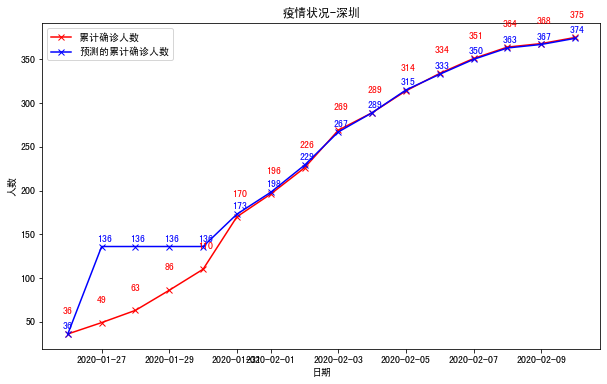

confirm_pred [ 36 136 136 136 136 173 198 229 267 289 315 333 350 363 367 374 396 417
 439 462 486]


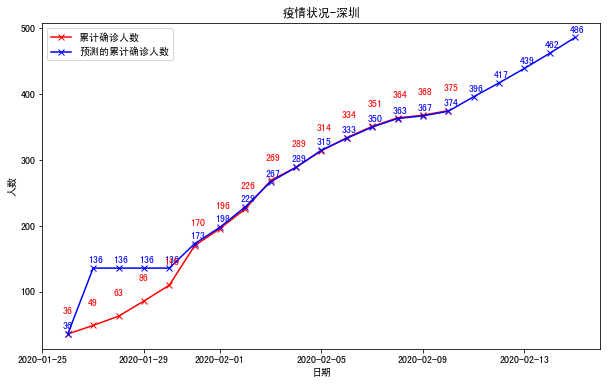

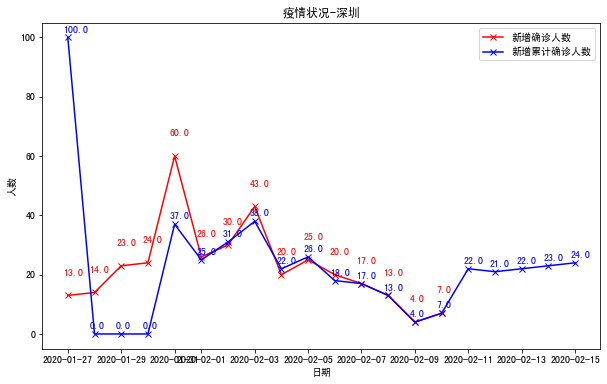

In [86]:
load_model_predict(model_city_date_path, data_sz, city_name='深圳')

In [74]:
data_wh = read_data('./ncov/data/wuhan_截至0209_24时.csv')
data_wh

,confirmed,suspected,dead,cured,time,I
0,258,0,6,25,2020-01-20,227
1,363,0,9,28,2020-01-21,326
2,425,0,17,28,2020-01-22,380
3,495,0,23,31,2020-01-23,441
4,572,0,38,32,2020-01-24,502
5,618,0,45,40,2020-01-25,533
6,698,0,63,42,2020-01-26,593
7,1590,0,85,45,2020-01-27,1460
8,1905,0,104,78,2020-01-28,1723
9,2261,0,129,85,2020-01-29,2047


In [44]:
model_city_date_path = make_dir('wuhan','02-09')
features=['I', 'cured','dead']
I_init = float(data_wh['I'].iloc[0])
R_init = float(data_wh['cured'].iloc[0])
D_init = float(data_wh['dead'].iloc[0])
N = 2870000.
S,I,E,R,D = train(data_wh, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

s: 200244.22229081442
Training step:  1562
Loss: 262643.150237525
Training step:  1563
Loss: 200240.49017761837
Training step:  1564
Loss: 262639.5803193018
Training step:  1565
Loss: 200236.76408632394
Training step:  1566
Loss: 262636.0161326938
Training step:  1567
Loss: 200233.0440004545
Training step:  1568
Loss: 262632.45766228746
Training step:  1569
Loss: 200229.32990359957
Training step:  1570
Loss: 262628.9048927113
Training step:  1571
Loss: 200225.62177940964
Training step:  1572
Loss: 262625.3578086366
Training step:  1573
Loss: 200221.91961160663
Training step:  1574
Loss: 262621.81639487157
Training step:  1575
Loss: 200218.2233840037
Training step:  1576
Loss: 262618.28063618735
Training step:  1577
Loss: 200214.5330803833
Training step:  1578
Loss: 262614.75051738333
Training step:  1579
Loss: 200210.84868466324
Training step:  1580
Loss: 262611.2260234673
Training step:  1581
Loss: 200207.17018088582
Training step:  1582
Loss: 262607.7071394668
Training step:  1583
Lo

In [45]:
model_city_date_path='models/wuhan/02-09'

In [46]:
param = {'beta_model_1': 0.039265121494126254, 'gamma_2_model_1': 0.012185829495883437, 'N_model_1': 0, 'theta_model_1': 0.029595901217760776}

[  258   363   425   495   572   618   698  1590  1905  2261  2639  3215
  4109  5142  6384  8351 10117 11618 13603 14982 16902]


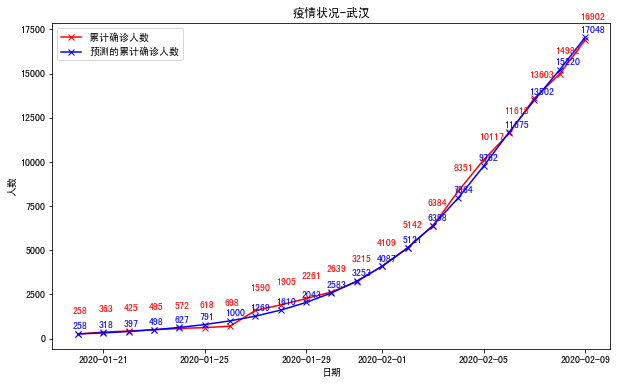

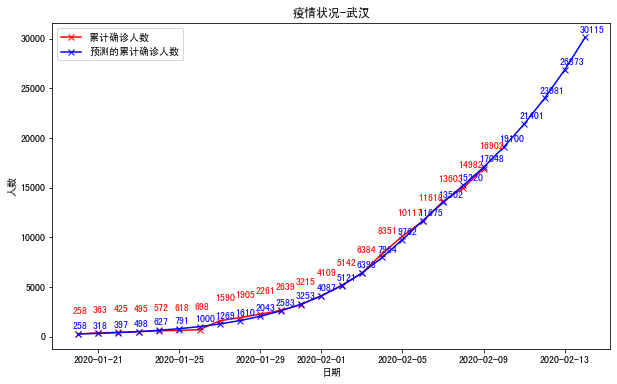

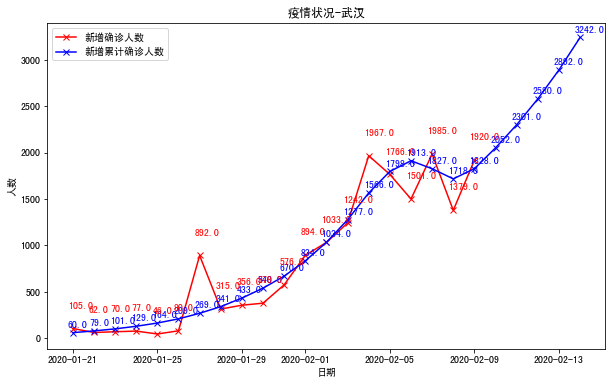

In [47]:
load_model_predict(model_city_date_path, data_wh, N_cur=param['N_model_1'],beta=param['beta_model_1'],gamma_2=param['gamma_2_model_1'],theta=param['theta_model_1'], city_name='武汉')

In [48]:
# param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 59170000.21805534, 'theta_model_2': 0.003805129170338665}
# i=2
# for k in list(param.keys()):
#     old_key = k
#     new_key = k.replace(f'_model_{i}','')
#     param[new_key]=param.pop(old_key)
# param

In [49]:
def train_with_city_data(data, N, date, cityname='深圳',max_epoches=2000):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    S,I,E,R,D = train(data, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=max_epoches)
    return model_city_date_path

In [50]:
data_hubei = read_data('./ncov/data/hubei_截至0209_24时i.csv')
data_hubei

,confirmed,suspected,dead,cured,close_contact,under_medical_observation,quit_medical_observation,time,I
0,270,0,6,25,1070,331,739,2020-01-20,239
1,375,0,9,28,1181,426,755,2020-01-21,338
2,444,0,17,28,2556,1693,863,2020-01-22,399
3,549,0,24,31,3653,2776,877,2020-01-23,494
4,729,0,39,32,5682,4711,971,2020-01-24,658
5,1052,0,52,42,7989,6904,1085,2020-01-25,958
6,1423,0,76,44,10394,9103,1291,2020-01-26,1303
7,2714,0,100,47,16904,15559,1345,2020-01-27,2567
8,3554,0,125,80,22095,20366,1729,2020-01-28,3349
9,4586,0,162,90,28780,26632,2148,2020-01-29,4334


In [51]:
# param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 0, 'theta_model_2': 0.003805129170338665}

In [52]:
model_city_date_path = train_with_city_data(data_hubei,59170000.,'02-08','湖北')

555
Loss: 872839.330382037
Training step:  1556
Loss: 669415.1439158998
Training step:  1557
Loss: 872823.1480143704
Training step:  1558
Loss: 669398.6483449434
Training step:  1559
Loss: 872806.9988472472
Training step:  1560
Loss: 669382.186563009
Training step:  1561
Loss: 872790.8827756529
Training step:  1562
Loss: 669365.7584629584
Training step:  1563
Loss: 872774.7996951195
Training step:  1564
Loss: 669349.3639379631
Training step:  1565
Loss: 872758.7495012515
Training step:  1566
Loss: 669333.0028816931
Training step:  1567
Loss: 872742.7320904778
Training step:  1568
Loss: 669316.6751884097
Training step:  1569
Loss: 872726.7473596112
Training step:  1570
Loss: 669300.3807527468
Training step:  1571
Loss: 872710.7952058689
Training step:  1572
Loss: 669284.1194699481
Training step:  1573
Loss: 872694.8755271897
Training step:  1574
Loss: 669267.8912355811
Training step:  1575
Loss: 872678.9882214658
Training step:  1576
Loss: 669251.6959455821
Training step:  1577
Loss: 87

[  270   375   444   549   729  1052  1423  2714  3554  4586  5806  7153
  9074 11177 13522 16678 19665 22112 24953 27100 29631]


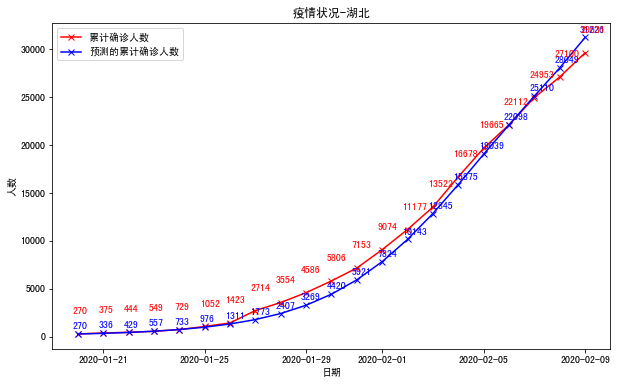

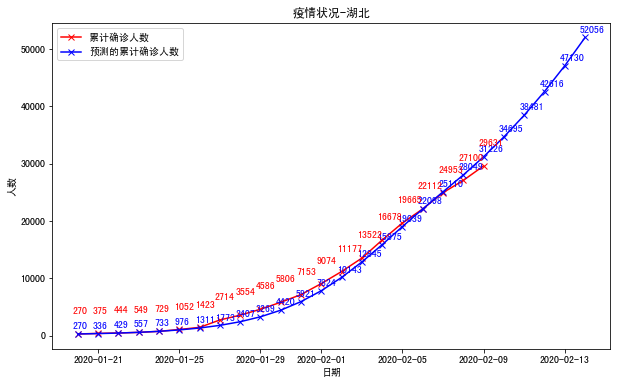

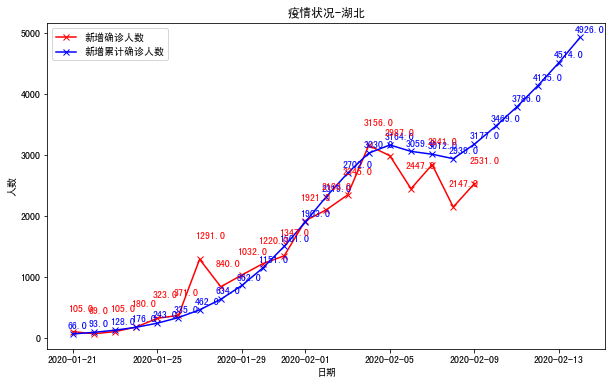

In [53]:
load_model_predict(model_city_date_path, data_hubei, city_name='湖北')

In [ ]:
def read_china_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [ ]:
data_china = read_china_data('./ncov/data/nation_截至0209_24时.csv')
data_china

In [65]:
N_init = (max(data_china['E'])+max(data_china['I'])+max(data_china['cured'])+max(data_china['dead']))*100.
model_city_date_path = train_with_city_data(data_china,N_init,'02-10','全国',max_epoches=6000)

505
Training step:  1564
Loss: 1651905.0796228957
Training step:  1565
Loss: 1270785.2603281913
Training step:  1566
Loss: 1651863.4592052896
Training step:  1567
Loss: 1270743.7335363738
Training step:  1568
Loss: 1651821.9438343046
Training step:  1569
Loss: 1270702.3114407167
Training step:  1570
Loss: 1651780.533124434
Training step:  1571
Loss: 1270660.9936566819
Training step:  1572
Loss: 1651739.2266921962
Training step:  1573
Loss: 1270619.779801752
Training step:  1574
Loss: 1651698.0241563572
Training step:  1575
Loss: 1270578.669495607
Training step:  1576
Loss: 1651656.9251378407
Training step:  1577
Loss: 1270537.6623597245
Training step:  1578
Loss: 1651615.9292589747
Training step:  1579
Loss: 1270496.7580171686
Training step:  1580
Loss: 1651575.0361438144
Training step:  1581
Loss: 1270455.9560927916
Training step:  1582
Loss: 1651534.245418209
Training step:  1583
Loss: 1270415.2562136666
Training step:  1584
Loss: 1651493.5567105804
Training step:  1585
Loss: 1270374

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198 40171]


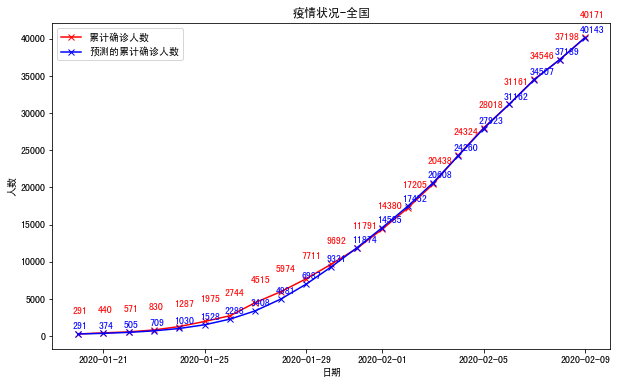

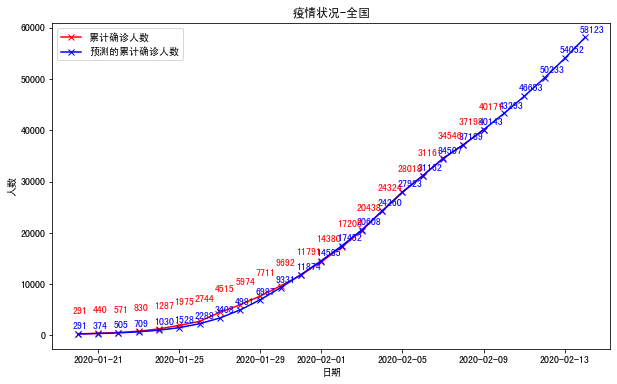

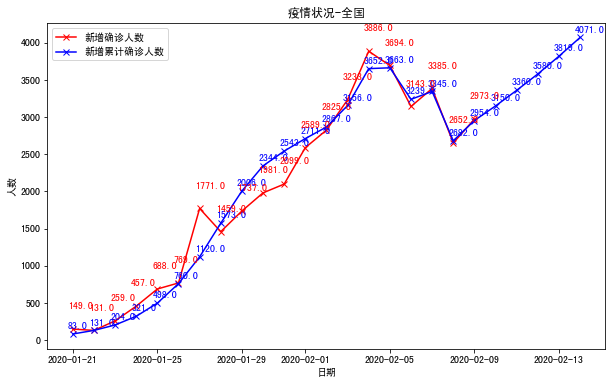

In [66]:
load_model_predict(model_city_date_path, data_china, city_name='全国')

In [ ]:
model_city_date_paths = ['models/shenzhen/02-08','models/wuhan/02-08','models/hubei/02-08','models/china/02-08']

In [ ]:
for model_i in range(len(model_city_date_paths)):
    print(model_city_date_paths[model_i]+':{')
    model_city_date_path = model_city_date_paths[model_i]
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    print(f'beta_model_{model_i}:{beta}')
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    print(f'gamma_2_model_{model_i}:{gamma_2}')
    N = []
    for i in range(len(model.SEIR_cells)):
        N.append(model.SEIR_cells[i].N.detach().numpy()[0])
    print(f'N_model_{model_i}:{N}')    
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    print(f'theta_model_{model_i}:{theta}')  
    print('}')

In [ ]:
len(model.SEIR_cells)

In [ ]:
beta_sz = []
for i in range(len(model.SEIR_cells)):
    beta_sz.append(model.SEIR_cells[i].beta.detach().numpy()[0])
beta_sz